## <center>Курсовой проект (Putyato Pavel) <center>


### Постановка задачи

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

### Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [1]:
#!pip install xgboost (conda install -c mndrake xgboost)
#!pip install lightgbm
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import random
import pickle
import matplotlib
from matplotlib import pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
import seaborn as sns
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 12})

In [5]:
def fix_outlier(df):
    df = preprocess_outlier(df, 'Annual Income', threshold=8000000)
    df = preprocess_outlier(df, 'Tax Liens', threshold=7)
    df = preprocess_outlier(df, 'Number of Open Accounts', threshold=40)
    df = preprocess_outlier(df, 'Years of Credit History', threshold=50)
    df = preprocess_outlier(df, 'Maximum Open Credit', threshold=50000000)
    df = preprocess_outlier(df, 'Number of Credit Problems', threshold=5)
    df = preprocess_outlier(df, 'Months since last delinquent', threshold=48)
    df = preprocess_outlier(df, 'Current Loan Amount', threshold= 40000000)
    df = preprocess_outlier(df, 'Current Credit Balance', threshold=400000)
    df = preprocess_outlier(df, 'Monthly Debt', threshold=80000)
    df = preprocess_outlier(df, 'Credit Score', threshold=1000)
    
    return df

In [6]:
def preprocess_outlier(df, col, threshold):
    df.loc[df[col] > threshold, col] = np.nan
    return df

In [7]:
def fill_data(df):
    for i in df:
        column_mode = df[i].mode()[0]
        df[i] = df[i].fillna(column_mode)
    
    return df

In [8]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [9]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

### Загрузка данных

In [10]:
# input
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'


df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [11]:
df_train.tail(n=5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


In [12]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [13]:
df_train.tail(n=5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


**Обзор обучающего датасета**

In [14]:
df_train.shape

(7500, 17)

In [15]:
df_train.isna().sum().sum()

7580

In [16]:
invalid_data_rate = 7580 / (7500 * 16) *100
invalid_data_rate

6.316666666666666

In [17]:
df_test.shape

(2500, 16)

In [18]:
df_test.isna().sum().sum()

2473

In [19]:
invalid_data_rate = 2473 / (2500 * 16) * 100
invalid_data_rate

6.1825

**Обзор целевой переменной**

In [20]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [21]:
disbalance = df_train['Credit Default'].value_counts()[0] / df_train['Credit Default'].value_counts()[1]
disbalance

2.549455750118315

В два с половиной раза больше клиентов, которые платят по кредиту - это хорошо (для банка). И нехватает 6% данных - это плохо.

In [22]:
df_train[df_train['Credit Default'] == 0].mean()

Annual Income                   1.418047e+06
Tax Liens                       2.598849e-02
Number of Open Accounts         1.104214e+01
Years of Credit History         1.840817e+01
Maximum Open Credit             1.088422e+06
Number of Credit Problems       1.637275e-01
Months since last delinquent    3.465681e+01
Bankruptcies                    1.167938e-01
Current Loan Amount             1.640219e+07
Current Credit Balance          2.937194e+05
Monthly Debt                    1.817643e+04
Credit Score                    7.235779e+02
Credit Default                  0.000000e+00
dtype: float64

In [23]:
df_train[df_train['Credit Default'] == 1].mean()

Annual Income                   1.224243e+06
Tax Liens                       4.070043e-02
Number of Open Accounts         1.135731e+01
Years of Credit History         1.808623e+01
Maximum Open Credit             5.798982e+05
Number of Credit Problems       1.859915e-01
Months since last delinquent    3.478128e+01
Bankruptcies                    1.180654e-01
Current Loan Amount             3.266510e+05
Current Credit Balance          2.799256e+05
Monthly Debt                    1.866635e+04
Credit Score                    2.327549e+03
Credit Default                  1.000000e+00
dtype: float64

Клиенты не выполняющие кледитные обязательства в среднем имеют меньший "Annual Income", больший "Tax Liens", больше "Number of Open Accounts", меньше "Years of Credit History", им выдают меньше "Maximum Open Credit", у них больше "Number of Credit Problems", странно что в среднем показатель "Months since last delinquent" почти равны - это говорит что в общем то эти две категории могут с одинаковой долей вероятности задержать платеж, чаще банкротятся "Bankruptcies", больше "Current Loan Amount" и меньше "Current Credit Balance" - что говорит о том что есть разница в оплате на этапах жизни кредита, у них больше "Monthly Debt", и больше "Credit Score" - но это скорее всего ошибка в данных.

In [24]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [26]:
# проверка размерности
df_train.shape[1]-1 == df_test.shape[1]

True

In [27]:
# объединение train и test
data = pd.concat([df_train, df_test], axis=0)
data = data.reset_index(drop=True)
data.shape

(10000, 17)

In [28]:
x_train = data[data["Credit Default"].notnull()]
x_test = data[data["Credit Default"].isnull()]

In [29]:
x_test.shape

(2500, 17)

In [30]:
data.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1.0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0.0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0.0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0.0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1.0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0.0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1.0
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0.0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1.0


**Обзор количественных признаков**

In [31]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Обзор номинативных признаков**

In [32]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [33]:
obj_features = df_train.select_dtypes(include='object').columns
obj_features

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

### Приведение типов данных

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                10000 non-null  object 
 1   Annual Income                 7930 non-null   float64
 2   Years in current job          9543 non-null   object 
 3   Tax Liens                     10000 non-null  float64
 4   Number of Open Accounts       10000 non-null  float64
 5   Years of Credit History       10000 non-null  float64
 6   Maximum Open Credit           10000 non-null  float64
 7   Number of Credit Problems     10000 non-null  float64
 8   Months since last delinquent  4561 non-null   float64
 9   Bankruptcies                  9983 non-null   float64
 10  Purpose                       10000 non-null  object 
 11  Term                          10000 non-null  object 
 12  Current Loan Amount           10000 non-null  float64
 13  Cu

In [35]:
for colname in ['Home Ownership', 'Years in current job', 'Purpose',  'Term']:
    data[colname] = data[colname].astype(str)

In [36]:
data.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                  float64
dtype: object

### Анализ данных

In [37]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = data.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = data.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [38]:
# обзор целевой переменной
x_train['Credit Default'].value_counts()

0.0    5387
1.0    2113
Name: Credit Default, dtype: int64

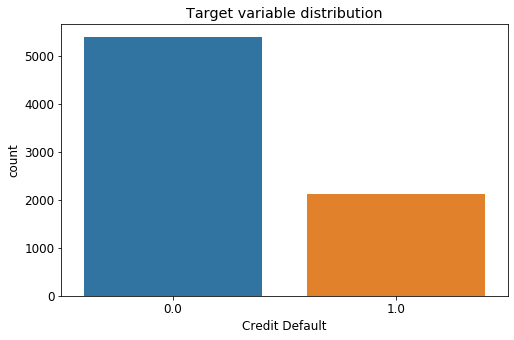

In [39]:
plt.figure(figsize=(8, 5))

sns.countplot(x='Credit Default', data=data)

plt.title('Target variable distribution')
plt.show()

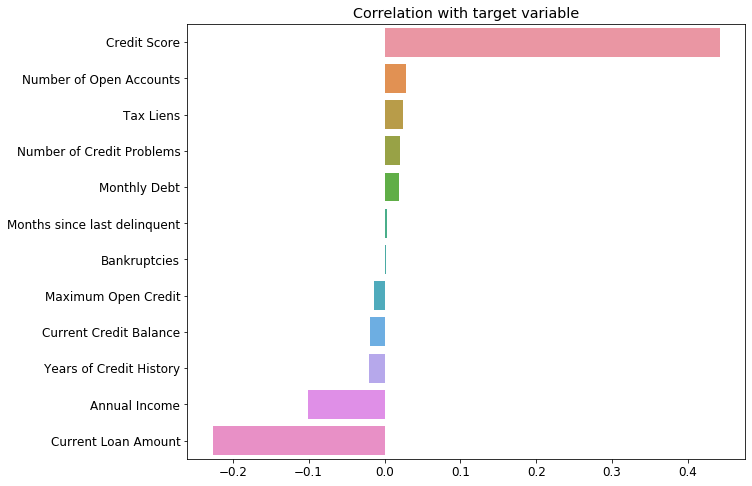

In [40]:
corr_with_target = data[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Оценка признака "Credit Score" в разрезе целевой переменной**

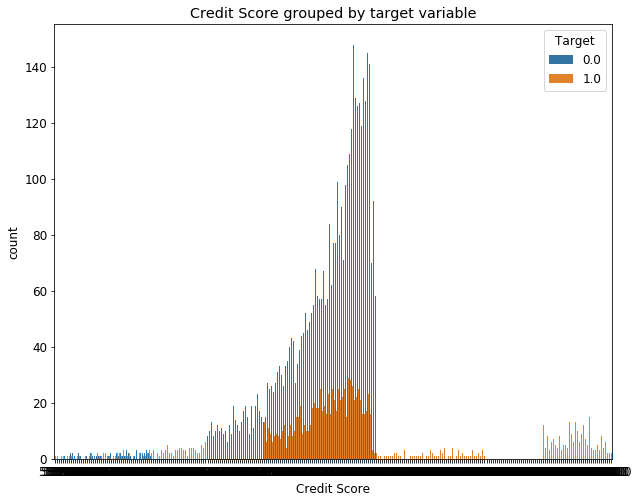

In [41]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Credit Score", hue=TARGET_NAME, data=data)
plt.title('Credit Score grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Матрица корреляций**

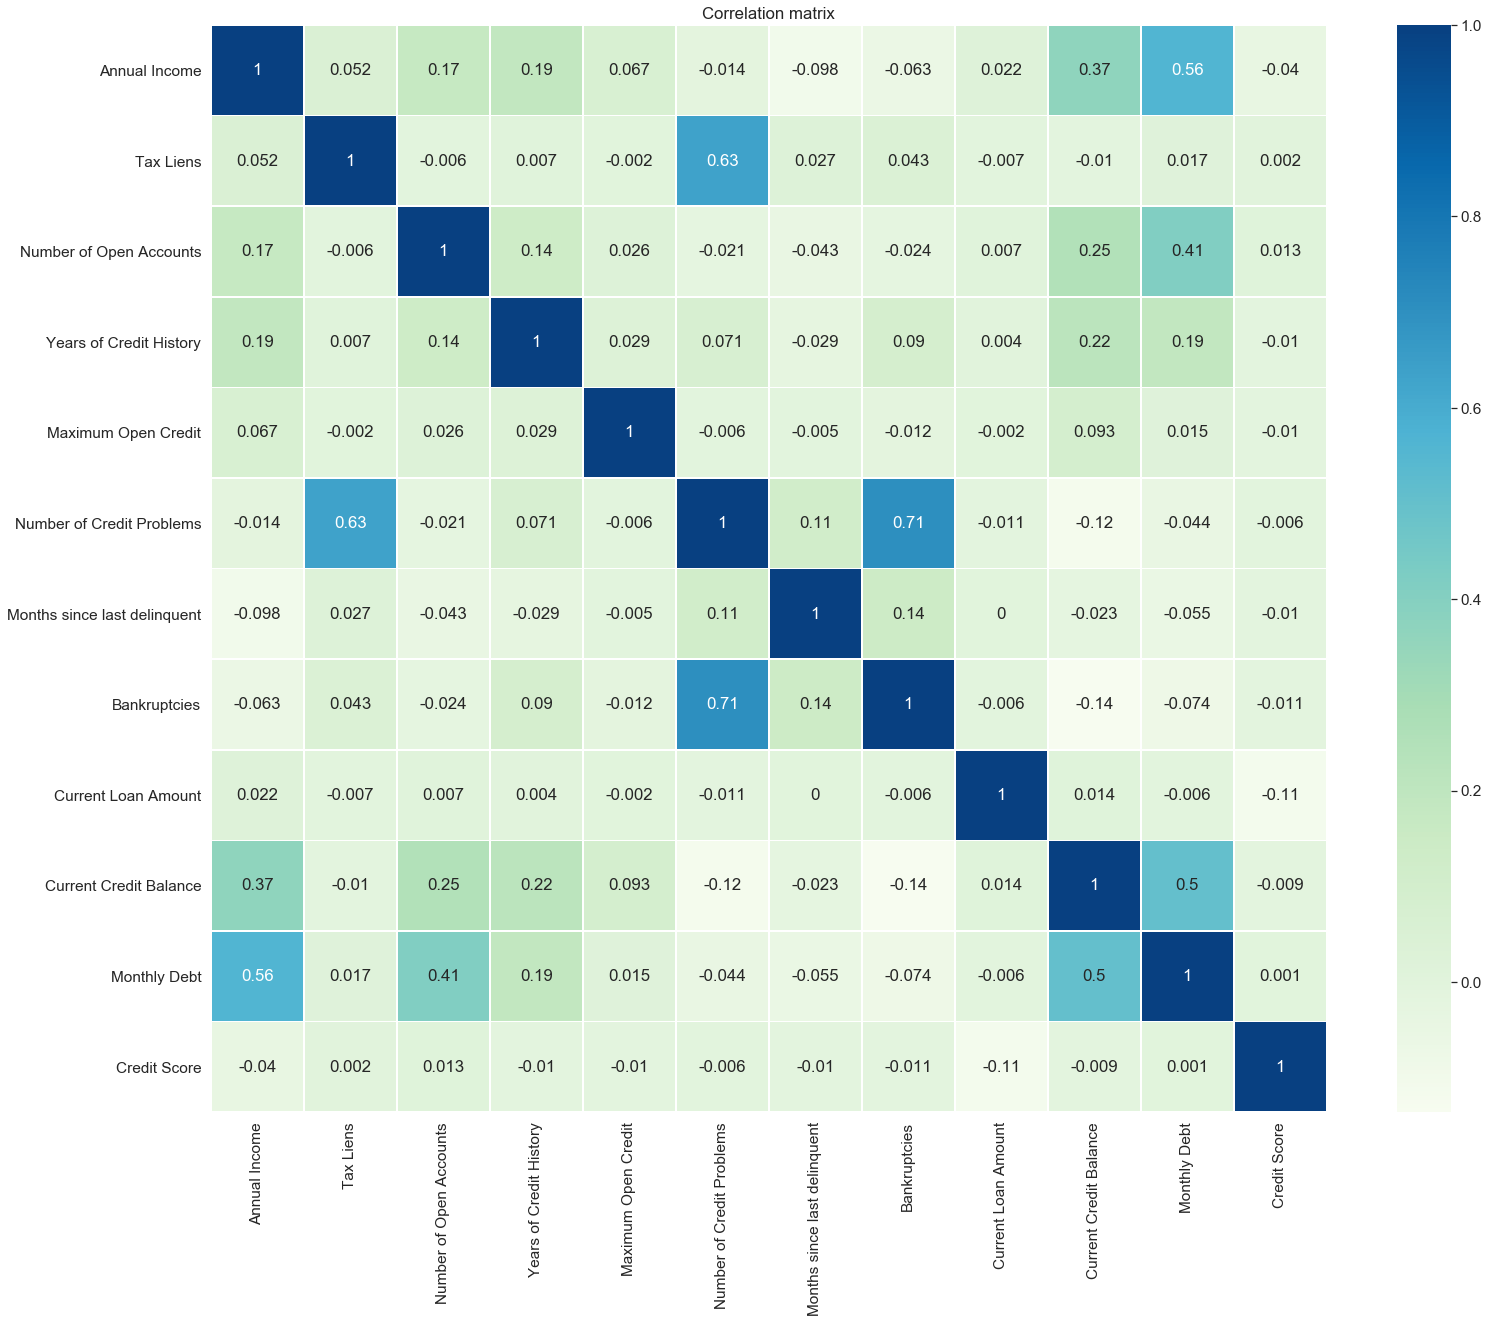

In [42]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(data[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Обзор категориальных признаков**

In [43]:
for cat_colname in data.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(data[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    4862
Rent             4224
Own Home          895
Have Mortgage      19
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    3142
2 years       917
3 years       848
< 1 year      770
5 years       685
1 year        657
4 years       621
6 years       563
7 years       536
nan           457
8 years       446
9 years       358
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      7917
other                    905
home improvements        552
business loan            159
buy a car                130
medical bills             98
buy house                 53
take a trip               51
major purchase            49
small business            31
wedding                   17
educational expenses      13
moving               

### Обработка пропусков и выбросов по каждому признаку

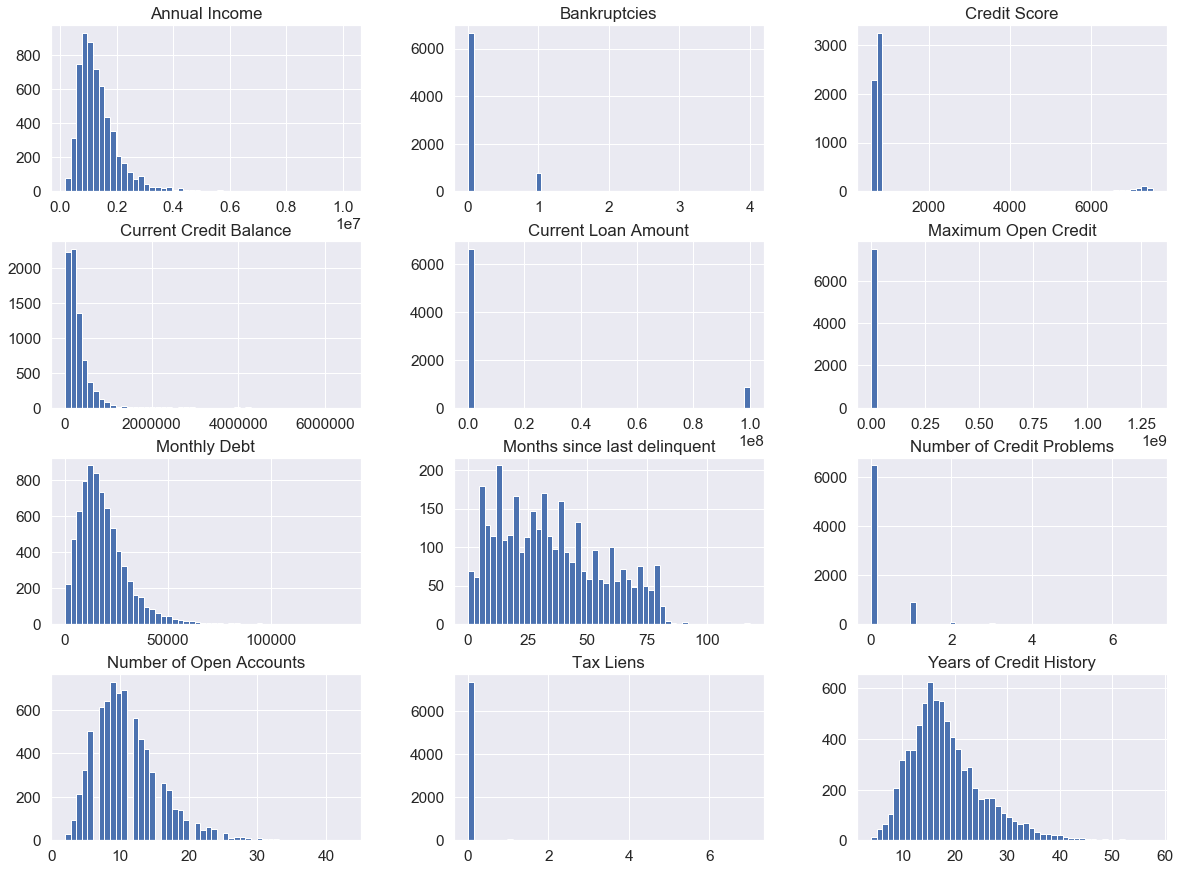

In [44]:
df_train[['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History',
          'Maximum Open Credit','Number of Credit Problems','Months since last delinquent',
          'Bankruptcies','Current Loan Amount', 'Current Credit Balance',
         'Monthly Debt', 'Credit Score']].hist(bins=50, figsize=(20,15))
plt.show()

In [45]:
data.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.930000e+03,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.00000,4561.000000,9983.000000,1.000000e+04,1.000000e+04,10000.000000,7930.000000,7500.000000
mean,1.366525e+06,0.031400,11.14430,18.319580,8.865079e+05,0.16800,34.564569,0.114595,1.194381e+07,2.914741e+05,18303.675600,1171.992182,0.281733
std,8.638276e+05,0.304341,4.89476,7.095357,1.389982e+07,0.51459,21.771990,0.349729,3.200878e+07,3.339979e+05,11831.647516,1639.812951,0.449874
min,1.065330e+05,0.000000,1.00000,3.900000,0.000000e+00,0.00000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.459892e+05,0.000000,8.00000,13.500000,2.788115e+05,0.00000,16.000000,0.000000,1.805485e+05,1.132258e+05,10059.750000,711.000000,0.000000
50%,1.168814e+06,0.000000,10.00000,17.000000,4.781810e+05,0.00000,32.000000,0.000000,3.117180e+05,2.090190e+05,16200.000000,731.000000,0.000000
75%,1.638693e+06,0.000000,14.00000,22.000000,7.943595e+05,0.00000,50.000000,0.000000,5.210700e+05,3.619500e+05,23888.250000,743.000000,1.000000
max,1.497561e+07,15.000000,48.00000,57.700000,1.304726e+09,15.00000,118.000000,5.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [46]:
len(data) - data.count()

Home Ownership                     0
Annual Income                   2070
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    5439
Bankruptcies                      17
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    2070
Credit Default                  2500
dtype: int64

**Home Ownership**

In [47]:
data['Home Ownership'].value_counts()

Home Mortgage    4862
Rent             4224
Own Home          895
Have Mortgage      19
Name: Home Ownership, dtype: int64

**Annual Income**

In [48]:
data["Annual Income"].isnull().sum()

2070

In [49]:
# проверим, есть ли с нулевым значением
data.loc[(data["Annual Income"] == 0)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [50]:
data["Annual Income"].describe()

count    7.930000e+03
mean     1.366525e+06
std      8.638276e+05
min      1.065330e+05
25%      8.459892e+05
50%      1.168814e+06
75%      1.638693e+06
max      1.497561e+07
Name: Annual Income, dtype: float64

In [51]:
# так как ежемесячный платеж сильно связан с годовым доходом, посчитаем примерно, во сколько раз, создадим новую переменную
data['ratio_ann_income/monthlydebt'] = data['Annual Income'] / data['Monthly Debt']

In [52]:
data["ratio_ann_income/monthlydebt"].describe()

count    7930.000000
mean             inf
std              NaN
min        30.074509
25%        52.863297
50%        71.426678
75%       107.139192
max              inf
Name: ratio_ann_income/monthlydebt, dtype: float64

In [53]:
# заполняю пропуски так: ежемесячный платеж умножить на случайное отношенинии годового дохода к ежемесячному платежу
data.loc[data['Annual Income'].isnull(), "Annual Income"] = data['Monthly Debt'] * random.randrange(30,110,10)

In [54]:
# удаляю вспомогательное отношение
del data['ratio_ann_income/monthlydebt']

In [55]:
data["Annual Income"].isnull().sum()

0

In [56]:
data["Annual Income"].describe()

count    1.000000e+04
mean     1.465331e+06
std      9.590046e+05
min      0.000000e+00
25%      8.622912e+05
50%      1.242666e+06
75%      1.787012e+06
max      1.497561e+07
Name: Annual Income, dtype: float64

In [57]:
data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,nan,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1.0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0.0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0.0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0.0


**Years in current job**

In [58]:
data['Years in current job'].value_counts()

10+ years    3142
2 years       917
3 years       848
< 1 year      770
5 years       685
1 year        657
4 years       621
6 years       563
7 years       536
nan           457
8 years       446
9 years       358
Name: Years in current job, dtype: int64

In [59]:
# есть выброс nan, заменим его на моду
data.replace({'Years in current job': {'nan':data['Years in current job'].mode()[0]}}, inplace=True)

In [60]:
data['Years in current job'].value_counts()

10+ years    3599
2 years       917
3 years       848
< 1 year      770
5 years       685
1 year        657
4 years       621
6 years       563
7 years       536
8 years       446
9 years       358
Name: Years in current job, dtype: int64

**Tax Liens**

In [61]:
data['Tax Liens'].value_counts()

0.0     9811
1.0      128
2.0       35
3.0       11
4.0        7
5.0        3
6.0        3
15.0       1
7.0        1
Name: Tax Liens, dtype: int64

In [62]:
data.loc[(data['Tax Liens'] > 3)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1129,Rent,1691019.0,5 years,4.0,11.0,20.4,681934.0,6.0,71.0,2.0,major purchase,Long Term,543906.0,116014.0,38753.0,693.0,0.0
1214,Rent,3061584.0,2 years,6.0,14.0,28.9,949564.0,6.0,67.0,0.0,debt consolidation,Short Term,99999999.0,352640.0,29595.0,740.0,0.0
2716,Home Mortgage,2522611.0,10+ years,5.0,7.0,14.4,235994.0,6.0,56.0,1.0,business loan,Short Term,342650.0,110257.0,14610.0,711.0,0.0
3028,Rent,1733400.0,10+ years,4.0,11.0,25.0,344102.0,5.0,81.0,1.0,debt consolidation,Short Term,312444.0,230318.0,17334.0,NaN,1.0
3435,Rent,1231561.0,10+ years,5.0,9.0,16.0,518892.0,5.0,71.0,0.0,other,Long Term,345708.0,163571.0,17242.0,708.0,1.0
3814,Rent,1254513.0,1 year,4.0,5.0,10.5,122804.0,5.0,36.0,0.0,debt consolidation,Short Term,193864.0,31920.0,1965.0,716.0,1.0
4122,Home Mortgage,3297412.0,< 1 year,4.0,13.0,35.3,320474.0,4.0,37.0,0.0,other,Long Term,763620.0,100472.0,31875.0,647.0,0.0
4774,Own Home,1268896.0,10+ years,4.0,15.0,15.8,3278000.0,5.0,18.0,1.0,debt consolidation,Short Term,268356.0,939892.0,14698.0,739.0,0.0
5373,Own Home,1711881.0,10+ years,6.0,12.0,15.4,551166.0,6.0,26.0,0.0,debt consolidation,Short Term,313654.0,295602.0,36092.0,741.0,0.0
5969,Rent,2897310.0,10+ years,7.0,9.0,20.0,434126.0,7.0,54.0,0.0,medical bills,Short Term,782782.0,275576.0,37182.0,716.0,0.0


Есть значения 4,5,6,7,15 - но их очень мало

"Tax Liens" - Это не столь важный признак, преобразуем его в бинарный. Где 1 это люди имеющие налоговые льготы, а 0 - не имеют льгот.

In [63]:
df_train["Tax Liens"].map({0:0}).fillna(1).value_counts(normalize=True)

0.0    0.982133
1.0    0.017867
Name: Tax Liens, dtype: float64

In [64]:
df_train["Tax Liens binary"] = df_train["Tax Liens"].map({0:0}).fillna(1)
df_train.groupby(["Tax Liens binary"])["Credit Default"].agg([np.mean, np.size])

,mean,size
Tax Liens binary,,
0.0,0.280342,7366
1.0,0.358209,134


**Number of Open Accounts**

In [65]:
data['Number of Open Accounts'].value_counts()

9.0     973
11.0    903
10.0    895
8.0     861
7.0     789
12.0    766
6.0     687
13.0    643
14.0    579
5.0     431
15.0    410
16.0    346
17.0    298
4.0     275
18.0    195
19.0    185
20.0    130
3.0     124
21.0    107
23.0     76
22.0     75
24.0     59
25.0     38
2.0      35
27.0     24
26.0     17
28.0     17
30.0     17
29.0     11
33.0      8
31.0      7
32.0      6
34.0      3
37.0      2
41.0      1
48.0      1
38.0      1
1.0       1
36.0      1
42.0      1
35.0      1
43.0      1
Name: Number of Open Accounts, dtype: int64

Здесь данные в порядке..

**Years of Credit History**

In [66]:
data['Years of Credit History'].value_counts()

16.0    131
15.0    126
16.5    126
17.0    116
14.0    115
       ... 
36.1      1
48.3      1
35.7      1
49.3      1
45.9      1
Name: Years of Credit History, Length: 423, dtype: int64

In [67]:
data.loc[(data["Years of Credit History"] == 0)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [68]:
data.loc[(data["Years of Credit History"] > 50 )]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
247,Home Mortgage,1893426.0,10+ years,0.0,7.0,52.2,711524.0,0.0,NaN,0.0,debt consolidation,Long Term,429880.0,500802.0,41024.0,654.0,1.0
476,Home Mortgage,1076768.0,10+ years,0.0,14.0,57.7,432124.0,0.0,24.0,0.0,debt consolidation,Long Term,558360.0,186219.0,13818.0,667.0,1.0
3091,Rent,582141.0,10+ years,0.0,7.0,50.9,487498.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,228190.0,7180.0,750.0,0.0
3628,Own Home,376314.0,10+ years,0.0,8.0,51.3,139436.0,1.0,NaN,1.0,debt consolidation,Short Term,78980.0,99712.0,9972.0,720.0,0.0
4301,Home Mortgage,2828000.0,10+ years,0.0,19.0,51.9,1602524.0,0.0,17.0,0.0,home improvements,Short Term,108152.0,384750.0,28280.0,NaN,0.0
4716,Rent,1654100.0,10+ years,0.0,5.0,51.5,485672.0,0.0,14.0,0.0,debt consolidation,Long Term,614614.0,416518.0,16541.0,NaN,1.0
5673,Home Mortgage,949810.0,10+ years,0.0,15.0,50.6,1180388.0,0.0,71.0,0.0,debt consolidation,Long Term,439912.0,486267.0,15514.0,727.0,0.0
7251,Home Mortgage,2251600.0,10+ years,0.0,8.0,51.0,1769900.0,0.0,27.0,0.0,debt consolidation,Long Term,439252.0,1369577.0,22516.0,NaN,1.0
8493,Home Mortgage,2535500.0,10+ years,0.0,19.0,50.9,941226.0,0.0,48.0,0.0,debt consolidation,Short Term,219252.0,481232.0,25355.0,NaN,NaN
8768,Own Home,1742661.0,8 years,0.0,19.0,53.4,1417174.0,0.0,NaN,0.0,debt consolidation,Short Term,448404.0,652346.0,35870.0,701.0,NaN


Здесь данные в порядке тоже..

**Maximum Open Credit**

In [69]:
data['Maximum Open Credit'].value_counts()

0.0         79
319110.0     5
294030.0     4
382954.0     4
334796.0     4
            ..
360118.0     1
430980.0     1
472736.0     1
225060.0     1
413644.0     1
Name: Maximum Open Credit, Length: 9096, dtype: int64

In [70]:
data['Maximum Open Credit'].sort_values().unique()

array([0.00000000e+00, 4.33400000e+03, 4.44400000e+03, ...,
       2.65512874e+08, 3.80052288e+08, 1.30472617e+09])

In [71]:
data["Maximum Open Credit"].max()

1304726170.0

In [72]:
data.loc[(data["Maximum Open Credit"] > 100000000 )]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0.0
617,Home Mortgage,549200.0,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0.0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0.0


Эти три суммы ошибочные, удаление их улучшит модели

In [73]:
data.drop([44, 617, 2617], inplace=True)

**Number of Credit Problems**

In [74]:
data['Number of Credit Problems'].value_counts()

0.0     8644
1.0     1161
2.0      122
3.0       42
5.0       11
4.0       10
6.0        4
7.0        2
15.0       1
Name: Number of Credit Problems, dtype: int64

Здесь все нормуль!

**Months since last delinquent**

In [75]:
data['Months since last delinquent'].value_counts()

14.0     104
16.0      91
33.0      90
29.0      90
13.0      90
        ... 
91.0       1
118.0      1
86.0       1
84.0       1
92.0       1
Name: Months since last delinquent, Length: 89, dtype: int64

In [76]:
 data.loc[data['Months since last delinquent'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
100,Own Home,337079.0,1 year,0.0,9.0,39.6,644204.0,0.0,0.0,NaN,educational expenses,Short Term,99999999.0,224770.0,4326.0,734.0,0.0
256,Rent,857660.0,1 year,0.0,6.0,19.7,291082.0,0.0,0.0,NaN,debt consolidation,Short Term,99999999.0,236816.0,3488.0,743.0,0.0
257,Home Mortgage,1961300.0,2 years,0.0,15.0,13.6,1556390.0,0.0,0.0,NaN,debt consolidation,Short Term,447480.0,524210.0,19613.0,NaN,0.0
898,Rent,739005.0,2 years,0.0,20.0,18.3,2177758.0,0.0,0.0,NaN,debt consolidation,Short Term,456808.0,607487.0,9669.0,732.0,1.0
1404,Rent,349391.0,< 1 year,0.0,4.0,12.7,0.0,0.0,0.0,NaN,other,Short Term,11242.0,0.0,1243.0,747.0,0.0
1501,Home Mortgage,2491800.0,10+ years,0.0,13.0,13.4,1662936.0,0.0,0.0,0.0,debt consolidation,Short Term,65582.0,465329.0,24918.0,NaN,0.0
2890,Home Mortgage,1230193.0,7 years,0.0,13.0,19.0,422884.0,0.0,0.0,0.0,debt consolidation,Short Term,394460.0,301663.0,20913.0,734.0,0.0
3063,Rent,464474.0,10+ years,0.0,5.0,14.9,38126.0,0.0,0.0,NaN,other,Short Term,44814.0,18373.0,929.0,7490.0,1.0
3252,Rent,832770.0,< 1 year,0.0,7.0,16.5,636856.0,0.0,0.0,NaN,business loan,Short Term,156970.0,52250.0,1145.0,750.0,0.0
3496,Rent,233567.0,1 year,0.0,7.0,11.7,0.0,0.0,0.0,NaN,educational expenses,Short Term,210166.0,0.0,0.0,746.0,0.0


In [77]:
data["Months since last delinquent"].isnull().sum()

5437

In [78]:
data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1.0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0.0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0.0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0.0


In [79]:
# предположим, что отсутствие данных - это отсутствие просрочек, и заменим на большое число месяцев
data.loc[data["Months since last delinquent"].isnull(), 'Months since last delinquent'] = 1000000000

**Bankruptcies**

In [80]:
data['Bankruptcies'].value_counts()

0.0    8909
1.0    1020
2.0      36
3.0      10
4.0       3
5.0       2
Name: Bankruptcies, dtype: int64

In [81]:
data.loc[(data["Bankruptcies"]>= 4, "Bankruptcies")] = data["Bankruptcies"].median()

In [82]:
data["Bankruptcies"].isnull().sum()

17

In [83]:
data.loc[(data["Bankruptcies"].isnull())]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
100,Own Home,337079.0,1 year,0.0,9.0,39.6,644204.0,0.0,0.0,NaN,educational expenses,Short Term,99999999.0,224770.0,4326.0,734.0,0.0
256,Rent,857660.0,1 year,0.0,6.0,19.7,291082.0,0.0,0.0,NaN,debt consolidation,Short Term,99999999.0,236816.0,3488.0,743.0,0.0
257,Home Mortgage,1961300.0,2 years,0.0,15.0,13.6,1556390.0,0.0,0.0,NaN,debt consolidation,Short Term,447480.0,524210.0,19613.0,NaN,0.0
898,Rent,739005.0,2 years,0.0,20.0,18.3,2177758.0,0.0,0.0,NaN,debt consolidation,Short Term,456808.0,607487.0,9669.0,732.0,1.0
1404,Rent,349391.0,< 1 year,0.0,4.0,12.7,0.0,0.0,0.0,NaN,other,Short Term,11242.0,0.0,1243.0,747.0,0.0
3063,Rent,464474.0,10+ years,0.0,5.0,14.9,38126.0,0.0,0.0,NaN,other,Short Term,44814.0,18373.0,929.0,7490.0,1.0
3252,Rent,832770.0,< 1 year,0.0,7.0,16.5,636856.0,0.0,0.0,NaN,business loan,Short Term,156970.0,52250.0,1145.0,750.0,0.0
3351,Home Mortgage,2226192.0,8 years,0.0,14.0,23.3,792836.0,0.0,73.0,NaN,debt consolidation,Short Term,528968.0,625157.0,23746.0,674.0,0.0
3401,Rent,326154.0,6 years,0.0,2.0,19.1,0.0,0.0,77.0,NaN,other,Short Term,99999999.0,0.0,1245.0,712.0,0.0
3496,Rent,233567.0,1 year,0.0,7.0,11.7,0.0,0.0,0.0,NaN,educational expenses,Short Term,210166.0,0.0,0.0,746.0,0.0


In [84]:
data.loc[data["Bankruptcies"].isnull(), 'Bankruptcies'] = data['Bankruptcies'].mode()[0]

In [85]:
data["Bankruptcies"].isnull().sum()

0

**Purpose**

In [86]:
data['Purpose'].value_counts()

debt consolidation      7916
other                    904
home improvements        552
business loan            159
buy a car                130
medical bills             98
buy house                 53
take a trip               50
major purchase            49
small business            31
wedding                   17
educational expenses      13
moving                    12
vacation                  11
renewable energy           2
Name: Purpose, dtype: int64

In [87]:
data["Purpose"].isnull().sum()

0

In [88]:
# заменим renewable energy на моду для более удобного деления на фолды
data.replace({'Purpose': {'renewable energy':data['Purpose'].mode()[0]}}, inplace=True)

In [89]:
data['Purpose'].value_counts()

debt consolidation      7918
other                    904
home improvements        552
business loan            159
buy a car                130
medical bills             98
buy house                 53
take a trip               50
major purchase            49
small business            31
wedding                   17
educational expenses      13
moving                    12
vacation                  11
Name: Purpose, dtype: int64

**Term**

In [90]:
data['Term'].value_counts()

Short Term    7414
Long Term     2583
Name: Term, dtype: int64

Здесь все нормуль!

In [91]:
data.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,9.997000e+03,9997.000000,9997.000000,9997.000000,9.997000e+03,9997.000000,9.997000e+03,9997.000000,9.997000e+03,9.997000e+03,9997.000000,7928.000000,7497.000000
mean,1.465260e+06,0.031409,11.143443,18.317235,6.916863e+05,0.167950,5.438632e+08,0.112234,1.194734e+07,2.911997e+05,18303.154446,1172.101287,0.281846
std,9.589437e+05,0.304386,4.895101,7.093686,1.330128e+06,0.514594,4.980972e+08,0.335935,3.201294e+07,3.335666e+05,11831.623158,1640.005402,0.449929
min,0.000000e+00,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000e+00,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.622960e+05,0.000000,8.000000,13.500000,2.786960e+05,0.000000,3.500000e+01,0.000000,1.806200e+05,1.131830e+05,10060.000000,711.000000,0.000000
50%,1.242657e+06,0.000000,10.000000,17.000000,4.781480e+05,0.000000,1.000000e+09,0.000000,3.117400e+05,2.088860e+05,16199.000000,731.000000,0.000000
75%,1.786969e+06,0.000000,14.000000,22.000000,7.942660e+05,0.000000,1.000000e+09,0.000000,5.210480e+05,3.616270e+05,23888.000000,743.000000,1.000000
max,1.497561e+07,15.000000,48.000000,57.700000,5.756256e+07,15.000000,1.000000e+09,3.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Current Loan Amount**

In [92]:
data['Current Loan Amount'].value_counts()

99999999.0    1167
270226.0         6
223322.0         6
218064.0         6
89298.0          6
              ... 
365508.0         1
56012.0          1
652740.0         1
248292.0         1
33792.0          1
Name: Current Loan Amount, Length: 6783, dtype: int64

In [93]:
data["Current Loan Amount"].isnull().sum()

0

In [94]:
data.loc[data['Current Loan Amount'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [95]:
data['Current Loan Amount'].max()

99999999.0

In [96]:
#это ошибка в данных скорее всего
data.loc[data['Current Loan Amount'] > 10000000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,1.000000e+09,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0.0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,1.000000e+09,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0.0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,7.300000e+01,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0.0
22,Rent,463790.0,10+ years,0.0,6.0,28.3,288442.0,0.0,1.000000e+09,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0.0
27,Rent,1004055.0,8 years,0.0,7.0,14.5,328394.0,0.0,1.000000e+09,0.0,debt consolidation,Short Term,99999999.0,195966.0,6041.0,734.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,Rent,5997920.0,2 years,0.0,11.0,17.6,1178584.0,0.0,4.600000e+01,0.0,debt consolidation,Short Term,99999999.0,350151.0,39686.0,750.0,NaN
9957,Home Mortgage,1437502.0,10+ years,0.0,16.0,13.0,750970.0,1.0,1.000000e+09,1.0,debt consolidation,Short Term,99999999.0,71991.0,25396.0,747.0,NaN
9961,Rent,613225.0,3 years,0.0,6.0,16.8,188078.0,0.0,1.000000e+09,0.0,other,Short Term,99999999.0,13319.0,7665.0,749.0,NaN
9967,Home Mortgage,939075.0,4 years,0.0,21.0,16.7,577940.0,0.0,1.000000e+09,0.0,debt consolidation,Short Term,99999999.0,269534.0,17216.0,737.0,NaN


In [97]:
# заменим на медиану
data.loc[data["Current Loan Amount"] > 10000000, 'Current Loan Amount'] = data['Current Loan Amount'].median()

In [98]:
data['Current Loan Amount'].value_counts()

311740.0    1168
270226.0       6
218064.0       6
89298.0        6
223322.0       6
            ... 
365508.0       1
56012.0        1
652740.0       1
248292.0       1
33792.0        1
Name: Current Loan Amount, Length: 6782, dtype: int64

**Current Credit Balance**

In [99]:
data['Current Credit Balance'].value_counts()

0.0         64
169917.0     5
191710.0     5
293094.0     5
136401.0     5
            ..
205200.0     1
195586.0     1
567568.0     1
616721.0     1
1824.0       1
Name: Current Credit Balance, Length: 8454, dtype: int64

In [100]:
data["Current Credit Balance"].isnull().sum()

0

С Current Credit Balance все тоже нормуль. Ноль в этих данных может быть.

**Monthly Debt**

In [101]:
data['Monthly Debt'].value_counts()

0.0        6
19667.0    4
13565.0    4
13162.0    4
19222.0    4
          ..
24710.0    1
9811.0     1
2931.0     1
16286.0    1
17.0       1
Name: Monthly Debt, Length: 8675, dtype: int64

In [102]:
data["Monthly Debt"].isnull().sum()

0

Здесь тоже все нормуль!

**Credit Score**

In [103]:
data['Credit Score'].value_counts()

740.0     219
747.0     217
741.0     205
748.0     201
745.0     201
         ... 
6710.0      1
6600.0      1
6680.0      1
620.0       1
6110.0      1
Name: Credit Score, Length: 278, dtype: int64

In [104]:
# credit score обычно максимум 850 или 900
data.loc[(data["Credit Score"] > 900)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
69,Home Mortgage,1408527.0,2 years,0.0,12.0,17.5,700062.0,0.0,2.100000e+01,0.0,other,Long Term,525998.0,174135.0,9320.0,6470.0,1.0
87,Home Mortgage,1533566.0,7 years,0.0,11.0,14.8,715462.0,0.0,1.900000e+01,0.0,debt consolidation,Short Term,210826.0,285475.0,18147.0,7440.0,1.0
94,Rent,1049294.0,3 years,0.0,5.0,6.1,249810.0,0.0,1.000000e+09,0.0,business loan,Short Term,337502.0,119529.0,15215.0,7010.0,1.0
96,Rent,757568.0,5 years,0.0,13.0,11.4,383548.0,0.0,1.000000e+09,0.0,debt consolidation,Short Term,210518.0,276583.0,11553.0,7320.0,1.0
116,Home Mortgage,1039984.0,10+ years,0.0,10.0,23.8,147950.0,0.0,6.300000e+01,0.0,debt consolidation,Short Term,224246.0,95456.0,13780.0,7390.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9949,Home Mortgage,1030902.0,10+ years,0.0,14.0,25.8,871838.0,0.0,1.000000e+09,0.0,debt consolidation,Long Term,533346.0,430692.0,27319.0,7300.0,NaN
9970,Home Mortgage,1116972.0,8 years,0.0,8.0,14.0,351560.0,0.0,1.000000e+09,0.0,debt consolidation,Long Term,258676.0,239552.0,14521.0,6470.0,NaN
9972,Home Mortgage,1951110.0,< 1 year,0.0,13.0,24.1,440506.0,1.0,1.000000e+09,1.0,debt consolidation,Short Term,129096.0,92454.0,25852.0,7410.0,NaN
9977,Rent,667603.0,2 years,0.0,5.0,12.3,333366.0,0.0,1.000000e+09,0.0,debt consolidation,Short Term,220858.0,152589.0,7622.0,7480.0,NaN


In [105]:
 # скорее всего здесь ошибка, разделим их на 10
data.loc[(data['Credit Score'] > 900), 'Credit Score'] = data.loc[(data['Credit Score'] > 900), 'Credit Score'] / 10

In [106]:
data.loc[(data["Credit Score"] > 900)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [107]:
data["Credit Score"].isnull().sum()

2069

In [108]:
data.loc[(data["Credit Score"].isnull())].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,Rent,1869200.0,7 years,0.0,12.0,14.6,366784.0,0.0,1.000000e+09,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1.0
8,Home Mortgage,1700.0,5 years,0.0,17.0,15.7,0.0,1.0,1.000000e+09,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0.0
9,Home Mortgage,1761300.0,1 year,0.0,10.0,24.6,511302.0,0.0,6.000000e+00,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1.0
10,Home Mortgage,1459200.0,< 1 year,0.0,7.0,11.5,256322.0,0.0,1.000000e+09,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,NaN,0.0
16,Rent,1884400.0,7 years,0.0,6.0,17.8,899492.0,0.0,1.000000e+09,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN,1.0


In [109]:
# заменим на моду
data.loc[data["Credit Score"].isnull(), 'Credit Score'] = data['Credit Score'].mode()[0]

## Работа с категориальными признаками

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                9997 non-null   object 
 1   Annual Income                 9997 non-null   float64
 2   Years in current job          9997 non-null   object 
 3   Tax Liens                     9997 non-null   float64
 4   Number of Open Accounts       9997 non-null   float64
 5   Years of Credit History       9997 non-null   float64
 6   Maximum Open Credit           9997 non-null   float64
 7   Number of Credit Problems     9997 non-null   float64
 8   Months since last delinquent  9997 non-null   float64
 9   Bankruptcies                  9997 non-null   float64
 10  Purpose                       9997 non-null   object 
 11  Term                          9997 non-null   object 
 12  Current Loan Amount           9997 non-null   float64
 13  Cur

In [111]:
for cat_colname in data.select_dtypes(include='object').columns[0:]:
    data = pd.concat([data, pd.get_dummies(data[cat_colname], prefix=cat_colname)], axis=1)

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 9999
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Home Ownership                  9997 non-null   object 
 1   Annual Income                   9997 non-null   float64
 2   Years in current job            9997 non-null   object 
 3   Tax Liens                       9997 non-null   float64
 4   Number of Open Accounts         9997 non-null   float64
 5   Years of Credit History         9997 non-null   float64
 6   Maximum Open Credit             9997 non-null   float64
 7   Number of Credit Problems       9997 non-null   float64
 8   Months since last delinquent    9997 non-null   float64
 9   Bankruptcies                    9997 non-null   float64
 10  Purpose                         9997 non-null   object 
 11  Term                            9997 non-null   object 
 12  Current Loan Amount             99

**Добавление новых признаков**

In [113]:
data['annual_income_bigger_than_mean'] = np.where(
    data["Annual Income"] > data["Annual Income"].mean(), 1, 0)

In [114]:
data.loc[data["Monthly Debt"] == 0, 'Monthly Debt'] = 1
data['ratio_ann_income/monthlydebt_'] =  data['Annual Income'] / data['Monthly Debt']

In [115]:
data["ratio_ann_income/monthlydebt_"].describe()

count    9.997000e+03
mean     3.495373e+02
std      1.543383e+04
min      0.000000e+00
25%      5.714322e+01
50%      8.510643e+01
75%      1.000000e+02
max      1.254513e+06
Name: ratio_ann_income/monthlydebt_, dtype: float64

In [116]:
gp = data.groupby(["Years in current job"])["Annual Income"].mean()
data["Mean_income_by_Years in current job"] = data["Years in current job"].map(gp.to_dict())

data["diff_Annual Income_and_mean_Annual Income_by_Years in current job"] = data["Annual Income"] - data["Mean_income_by_Years in current job"]
data["ratio_Annual Income_and_mean_Annual Income_by_Years in current job"] = data["Annual Income"] / data["Mean_income_by_Years in current job"] - 1

In [117]:
data['Credit Score_changed'] = np.where(
    data["Credit Score"] == data['Credit Score'].mode()[0], 1, 0)

### Стандартизация признаков

In [118]:
data.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_< 1 year',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improve

In [119]:
feature_names_for_stand = [
 'Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
'ratio_ann_income/monthlydebt_',
'Mean_income_by_Years in current job',
 'diff_Annual Income_and_mean_Annual Income_by_Years in current job',
 'ratio_Annual Income_and_mean_Annual Income_by_Years in current job'
]
data[feature_names_for_stand].dtypes

Annual Income                                                         float64
Tax Liens                                                             float64
Number of Open Accounts                                               float64
Years of Credit History                                               float64
Maximum Open Credit                                                   float64
Number of Credit Problems                                             float64
Months since last delinquent                                          float64
Bankruptcies                                                          float64
Current Loan Amount                                                   float64
Current Credit Balance                                                float64
Monthly Debt                                                          float64
Credit Score                                                          float64
ratio_ann_income/monthlydebt_                                   

In [120]:
scaler = StandardScaler()

data_norm = data.copy()
data_norm[feature_names_for_stand] = scaler.fit_transform(data_norm[feature_names_for_stand])

data = data_norm.copy()

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 9999
Data columns (total 54 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Home Ownership                                                      9997 non-null   object 
 1   Annual Income                                                       9997 non-null   float64
 2   Years in current job                                                9997 non-null   object 
 3   Tax Liens                                                           9997 non-null   float64
 4   Number of Open Accounts                                             9997 non-null   float64
 5   Years of Credit History                                             9997 non-null   float64
 6   Maximum Open Credit                                                 9997 non-null   float64
 7   Number of Credi

In [122]:
data.std()

Annual Income                                                         1.000050
Tax Liens                                                             1.000050
Number of Open Accounts                                               1.000050
Years of Credit History                                               1.000050
Maximum Open Credit                                                   1.000050
Number of Credit Problems                                             1.000050
Months since last delinquent                                          1.000050
Bankruptcies                                                          1.000050
Current Loan Amount                                                   1.000050
Current Credit Balance                                                1.000050
Monthly Debt                                                          1.000050
Credit Score                                                          1.000050
Credit Default                                      

## Разбиение на train и test

In [123]:
len(data) - data.count()

Home Ownership                                                           0
Annual Income                                                            0
Years in current job                                                     0
Tax Liens                                                                0
Number of Open Accounts                                                  0
Years of Credit History                                                  0
Maximum Open Credit                                                      0
Number of Credit Problems                                                0
Months since last delinquent                                             0
Bankruptcies                                                             0
Purpose                                                                  0
Term                                                                     0
Current Loan Amount                                                      0
Current Credit Balance   

In [124]:
# меняем название так как catboost не нравиться в названии  знак "<"
data.rename(columns={'Years in current job_< 1 year': 'Years in current job_less 1 year'}, inplace=True)

In [125]:
data.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_less 1 year',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home impr

In [126]:
x_train = data[data["Credit Default"].notnull()]
x_test = data[data["Credit Default"].isnull()]

In [127]:
new_feature_names = ['annual_income_bigger_than_mean', 'Mean_income_by_Years in current job',
 'diff_Annual Income_and_mean_Annual Income_by_Years in current job',
 'ratio_Annual Income_and_mean_Annual Income_by_Years in current job', 'ratio_ann_income/monthlydebt_', 'Credit Score_changed']

In [128]:
feature_names = ['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
'Home Ownership_Have Mortgage',
 'Years in current job_1 year',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_5 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_less 1 year',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding',
 'Term_Long Term',
 'Term_Short Term',]

target_name = 'Credit Default'

In [129]:
X = x_train[feature_names + new_feature_names]
y = x_train[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Балансировка целевой переменной

In [130]:
data_for_balancing = pd.concat([X_train, y_train], axis=1)
data_balanced = balance_df_by_target(data_for_balancing, target_name)
    
data_balanced[target_name].value_counts()

0.0    3622
1.0    2800
Name: Credit Default, dtype: int64

In [131]:
X_train = data_balanced.drop(columns=target_name)
y_train = data_balanced[target_name]

In [132]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.49      0.66      3622
         1.0       0.60      1.00      0.75      2800

    accuracy                           0.71      6422
   macro avg       0.80      0.75      0.71      6422
weighted avg       0.83      0.71      0.70      6422

TEST

              precision    recall  f1-score   support

         0.0       0.89      0.39      0.55      1762
         1.0       0.37      0.88      0.52       713

    accuracy                           0.53      2475
   macro avg       0.63      0.64      0.53      2475
weighted avg       0.74      0.53      0.54      2475

CONFUSION MATRIX

col_0           0.0   1.0
Credit Default           
0.0             695  1067
1.0              87   626


**Обучение и оценка финальной модели**

In [133]:
final_model = catb.CatBoostClassifier(class_weights=[1, 1.3], max_depth=3, l2_leaf_reg=15,
                                      random_state=21, n_estimators=100, silent=True)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.73      0.59      0.65      3622
         1.0       0.58      0.72      0.64      2800

    accuracy                           0.65      6422
   macro avg       0.65      0.66      0.65      6422
weighted avg       0.66      0.65      0.65      6422

TEST

              precision    recall  f1-score   support

         0.0       0.83      0.59      0.69      1762
         1.0       0.41      0.70      0.51       713

    accuracy                           0.62      2475
   macro avg       0.62      0.64      0.60      2475
weighted avg       0.71      0.62      0.64      2475

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1042  720
1.0              217  496


In [134]:
x_test.shape

(2500, 54)

In [135]:
x_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,annual_income_bigger_than_mean,ratio_ann_income/monthlydebt_,Mean_income_by_Years in current job,diff_Annual Income_and_mean_Annual Income_by_Years in current job,ratio_Annual Income_and_mean_Annual Income_by_Years in current job,Credit Score_changed
7500,Rent,-0.817566,4 years,-0.103195,-0.437897,-0.820099,-0.353907,-0.326391,-1.091936,-0.33411,...,0,0,0,1,0,-0.016169,-0.604352,-0.763089,-0.792428,1
7501,Rent,-1.286295,1 year,-0.103195,-1.050785,2.027646,-0.477978,-0.326391,-1.091936,-0.33411,...,0,0,0,1,0,-0.016168,-1.478143,-1.149746,-1.266177,0
7502,Home Mortgage,-0.326126,3 years,-0.103195,-0.233601,-0.650926,-0.366213,-0.326391,0.915804,-0.33411,...,0,0,0,1,0,-0.018661,-0.082712,-0.319663,-0.321022,0
7503,Home Mortgage,-0.255447,10+ years,-0.103195,0.992176,-0.185700,-0.176972,-0.326391,-1.091936,-0.33411,...,0,0,0,1,0,-0.019779,0.919753,-0.345309,-0.326136,0
7504,Home Mortgage,0.913229,6 years,-0.103195,-0.029305,0.744751,0.387640,-0.326391,0.915804,-0.33411,...,0,0,1,0,1,-0.019088,-0.273748,0.943857,0.959439,0


In [136]:
x_valid = x_test[feature_names + new_feature_names]

In [137]:
x_valid

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,annual_income_bigger_than_mean,Mean_income_by_Years in current job,diff_Annual Income_and_mean_Annual Income_by_Years in current job,ratio_Annual Income_and_mean_Annual Income_by_Years in current job,ratio_ann_income/monthlydebt_,Credit Score_changed
7500,-0.817566,-0.103195,-0.437897,-0.820099,-0.353907,-0.326391,-1.091936,-0.334110,-0.862181,-0.555520,...,0,0,0,1,0,-0.604352,-0.763089,-0.792428,-0.016169,1
7501,-1.286295,-0.103195,-1.050785,2.027646,-0.477978,-0.326391,-1.091936,-0.334110,-1.353343,-0.735010,...,0,0,0,1,0,-1.478143,-1.149746,-1.266177,-0.016168,0
7502,-0.326126,-0.103195,-0.233601,-0.650926,-0.366213,-0.326391,0.915804,-0.334110,-0.642147,-0.433847,...,0,0,0,1,0,-0.082712,-0.319663,-0.321022,-0.018661,0
7503,-0.255447,-0.103195,0.992176,-0.185700,-0.176972,-0.326391,-1.091936,-0.334110,-0.541758,-0.233850,...,0,0,0,1,0,0.919753,-0.345309,-0.326136,-0.019779,0
7504,0.913229,-0.103195,-0.029305,0.744751,0.387640,-0.326391,0.915804,-0.334110,2.727431,0.402313,...,0,0,1,0,1,-0.273748,0.943857,0.959439,-0.019088,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.464292,-0.103195,0.583583,1.520127,-0.099645,1.616986,-1.091936,2.642803,0.008841,-0.385144,...,0,0,0,1,0,0.919753,-0.555121,-0.524299,-0.018256,0
9996,1.912971,-0.103195,0.787880,-0.185700,0.786500,-0.326391,-1.091936,-0.334110,0.923638,3.441972,...,0,0,0,1,1,-0.695524,1.988899,2.077734,-0.016169,1
9997,-0.306034,-0.103195,7.529650,-0.777806,0.762930,-0.326391,0.915804,-0.334110,0.701807,1.154965,...,0,0,0,1,0,-0.695524,-0.240395,-0.251132,-0.020592,0
9998,-0.773536,-0.103195,0.583583,1.477834,0.191039,-0.326391,0.915804,-0.334110,-0.306062,0.299950,...,0,0,0,1,0,0.919753,-0.865800,-0.817727,-0.019177,0


In [138]:
Credit_Default_predicted = final_model.predict(x_valid)
Credit_Default_predicted

array([1., 1., 1., ..., 1., 0., 1.])

In [139]:
len(Credit_Default_predicted)

2500

In [140]:
results = pd.DataFrame({'Credit_Default_predicted': Credit_Default_predicted}, columns=['Credit_Default_predicted'])
results

,Credit_Default_predicted
0,1.0
1,1.0
2,1.0
3,0.0
4,1.0
...,...
2495,0.0
2496,0.0
2497,1.0
2498,0.0


### Сохранение предсказания

In [141]:
RESULTS_FILE_PATH = 'PPutyato_predictions.csv'
results.to_csv(RESULTS_FILE_PATH, index=False)